# Préambule

## Introduction & Contexte

Ce projet a été réalisé par 3 étudiants de Master 1 à l'ENSAE, dans le cadre du cours "Python for Data Science". L'idée de ce projet vient d'une intuition que nous avons eu selon laquelle il était possible de prédire le succès d'un jeu vidéo auprès des utilisateurs à partir de certaines de ses caractéristiques. L'objectif principal de ce travail est donc de tenter de vérifier ou infirmer cette intuition à l'aide de techniques statistiques de traitement de données. 

De plus, nous voulions y incorporer une partie plus originale (traitement d'images...)

# Importation des modules 

## Modules de webscrapping

On installe les packages utiles au Webscrapping des données sur les jeux

In [1]:
# On importe les packages
!pip install unicode
!pip install unidecode
!pip install requests_html
!pip install igdb-api-v4
!pip install requests

import requests 
import urllib
import bs4
from requests_html import HTMLSession
from tqdm import tqdm
from unidecode import unidecode
import datetime
import time

from igdb.wrapper import IGDBWrapper
from igdb.igdbapi_pb2 import GenreResult
from igdb.igdbapi_pb2 import ThemeResult
from igdb.igdbapi_pb2 import GameResult
from igdb.igdbapi_pb2 import InvolvedCompanyResult
from igdb.igdbapi_pb2 import PlayerPerspectiveResult
from igdb.igdbapi_pb2 import MultiplayerModeResult
from igdb.igdbapi_pb2 import ArtworkResult
from igdb.igdbapi_pb2 import AgeRatingResult
from igdb.igdbapi_pb2 import CompanyResult
from igdb.igdbapi_pb2 import CollectionResult
from igdb.igdbapi_pb2 import GameEngineResult
from igdb.igdbapi_pb2 import FranchiseResult


#Cela va run le notebook functions_scrapping et nous allons pouvoir utiliser les fonctions dans ce notebook
#%run -i functions_scrapping.ipynb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 74.3 MB/s eta 0:00:00:00:0100:01
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1256 sha256=1a9b5c5b516360cdfa91b6b287bb50cb9446043f6281fbda9750d59b130a45fc
  Stored in directory: /home/onyxia/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
Successfully built bs4


In [2]:
wrapper = IGDBWrapper("wlqlv1d19z5t69oqlf9xx69znfahze", "o2strnp2xj90l3p982n4jg9ko1utad")

## Importation des modules de Visualisation & Modélisation des données

In [3]:
#Là on importe les autres packages
#!pip install pandas_profiling 
#!pip install pydantic-settings


from collections import Counter
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
#from pandas_profiling import ProfileReport
#from pydantic_settings import BaseSettings

# I/ Récupération des données

## I/A Webscrapping des titres des jeux vidéos sur Wikipédia

A partir du site Wikipédia, nous allons récupérer les titres de tous les jeux vidéos sortis depuis l'année 2000. Par exemple, depuis l'URL : https://en.wikipedia.org/wiki/Category:2023_video_games nous avons accès à la liste de la quasi-totalité des jeux vidéos sortis en 2023. Nous allons donc modifier l'URL pour chaque année et constituer une liste (Liste_VG)

In [4]:
#Url initial : https://en.wikipedia.org/wiki/2023_in_video_games
Liste_VG = []

d = {15 : 10, 16 : 9, 17: 11, 18 : 9, 19 : 9, 20: 12, 21: 11, 22 : 7}
for i in range(15, 23) :
    
    
    response = requests.get(url="https://en.wikipedia.org/wiki/20"+str(i)+"_in_video_games")
    soup = bs4.BeautifulSoup(response.content, 'html.parser')
    tableau_participants = soup.findAll('table', {'class' : 'wikitable'})
    for j in range(d[i], d[i]+4) :
        rows = tableau_participants[j].find_all('tr')
        first = True
        for row in rows :
            if first :
                first = False
            else:
                title = row.find('i')
                if title != None :
                    Liste_VG.append((row.find('i').text))
                
                    
print(Liste_VG)

['Dark Souls II: Scholar of the First Sin', 'Box Boy!', 'DuckTales Remastered', 'Steven Universe: Attack the Light!', 'War for the Overworld', 'Stealth Inc. 2: A Game of Clones', 'Bastion', 'Dark Souls II: Scholar of the First Sin', 'Etrian Mystery Dungeon', 'Krinkle Krusher', 'MonsterBag', 'Mortal Kombat X', 'Stealth Inc. 2: A Game of Clones', 'Tower of Guns', 'Driver: Speedboat Paradise', 'Bloodsports.TV', 'Pokémon Rumble World', 'Affordable Space Adventures', 'I am Bread', 'Tower of Guns', 'Xenoblade Chronicles 3D', 'A-Train: City Simulator', 'Age of Wonders III', 'Grand Theft Auto V', 'Grand Theft Auto Online', 'Mortal Kombat X', 'Titan Souls', 'We Are Doomed', '3D Fantasy Zone II', 'Goat Simulator', 'Halo: Spartan Assault', 'Halo: Spartan Strike', 'Lost Within', 'Gradius V', 'Slow Down, Bull', "Assassin's Creed Chronicles: China", 'LA Cops', 'Shovel Knight', 'EA Sports UFC', 'Shooting Love 200X', 'Kalimba', 'Crypt of the Necrodancer', 'Dungeons 2', 'Happy Wars', "Shantae and the P

## I/B Récupération des notes des jeux

L'objectif de cette partie est d'extraire du site "Métacritic", un site spécialisé qui répertorie les avis de professionnels et d'utilisateurs sur les nouvelles sorties jeux vidéos. Pour chaque jeu dans la base de données du site, une note sur 100 est attribuée (moyenne des reviews de sites spécialisés jeux vidéos) et une note sur 10 attribuée par les utilisateurs du site. Nous allons ici récupérer pour chaque jeu ses notes Métacritic qui deviendront les variables que nous tenteront de prédire par la suite. 

On remarque que l'on peut atteindre la review du jeu à partir de l'URL, il suffit d'indiquer le titre du jeu dans l'URL, en faisant attention aux espaces. 

Ici, nous allons remarquer que l'accès à Métacritic est interdit via la bibliothèque Beautifoul Soup

In [5]:
#URL du site : https://www.metacritic.com/game/
#URL d'une recherche : https://www.metacritic.com/search/gran%20theft%20auto/
#URL d'une review : https://www.metacritic.com/game/grand-theft-auto-v/
#URL d'une review d'un autre site spécialisé : https://www.ign.com/games/grand-theft-auto-v

#Base URL de toutes les reviews
URL = "https://www.metacritic.com/game/"

#user_agent = {'User-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/62.0.3202.94 Safari/537.36'}
#site = requests.get(URLbis, user_agent)
#print(site.status_code)

In [6]:
def title_to_slug(title):
    
    title = title.lower()
    title = title.replace(':', '')
    title = title.replace('•', '-')
    title = title.replace(' – ', '')
    #ce ne sont pas exactement les mêmes tirets ici
    title = title.replace(' — ', '')
    title = title.replace(' - ', '')
    title = title.replace('/', '-')
    title = title.replace('.', '')
    title = title.replace('&', 'and')
    title = title.replace("'", '')
    title = title.replace('+', 'plus')
    title = title.replace('ō', 'o')
    title = title.replace(' ', '-')
    
    return(str(title))

On définit cette fonction qui va, pour une liste de titres de jeux donnée, récupérer les notes Métacritic sur la page web de la review du jeu en question. Ce sont ces notes que nous allons essayer de prédire par la suite car elles correspondent globablement à la mesure de l'accueil et de la qualité du jeu par les joueurs. 

Afin d'accélérer le code et sachant que nous allons utiliser uniquement le métascore qui reflète les avis de professionnels du milieu du jeu vidéo, nous allons ajouter à l'utilisateur la possibilité de choisir d'extraire le métascore ou le userscore

In [7]:
def recup_metascore(list, param) : 
    session = HTMLSession()
    liste_ratings = []

    if param == 1 :

        for i in range(len(list)) :
            #on reformate les titres extraits pour qu'ils aient le format des URL Métacritic
            title = unidecode(list[i])
            Url = URL + title_to_slug(title) + '/'

            #on get l'url
            DOM_Html = session.get(Url)
            chemin_metascore = DOM_Html.html.find('#__layout > div > div.c-layoutDefault_page > div.c-pageProductGame > div:nth-child(1) > div > div \
                                    > div.c-productHero_player-scoreInfo.u-grid.g-grid-container > \
                                    div.c-productHero_score-container.u-flexbox.u-flexbox-column.g-bg-white > \
                                    div.c-productHero_scoreInfo.g-inner-spacing-top-medium.g-outer-spacing-bottom-medium.g-outer-spacing-top-medium \
                                    > div:nth-child(1) > div > div.c-productScoreInfo_scoreContent.u-flexbox.u-flexbox-alignCenter.u-flexbox-justifyFlexEnd.g-width-100.u-flexbox-nowrap > \
                                    div.c-productScoreInfo_scoreNumber.u-float-right > div > div', first = True)
            #on extrait le rating
            if chemin_metascore != None :
                metacritic_rating_inter = chemin_metascore.attrs['title']
                metacritic_rating = metacritic_rating_inter.split(' ')[1]
            else : 
                metacritic_rating = 'N/A'

            liste_ratings.append([list[i], metacritic_rating])

    elif param == 2 : 

        for i in range(len(list)) :
            #on reformate les titres extraits pour qu'ils aient le format des URL Métacritic
            title = unidecode(list[i])
            Url = URL + title_to_slug(title) + '/'

            #on get l'url
            DOM_Html = session.get(Url)
            chemin_userscore = DOM_Html.html.find('#__layout > div > div.c-layoutDefault_page > div.c-pageProductGame > div:nth-child(1) > div > div > \
                                      div.c-productHero_player-scoreInfo.u-grid.g-grid-container > div.c-productHero_score-container.u-flexbox.u-flexbox-column.g-bg-white > \
                                      div.c-productHero_scoreInfo.g-inner-spacing-top-medium.g-outer-spacing-bottom-medium.g-outer-spacing-top-medium > \
                                      div.c-productScoreInfo.u-clearfix > div.c-productScoreInfo_scoreContent.u-flexbox.u-flexbox-alignCenter.u-flexbox-justifyFlexEnd.g-width-100.u-flexbox-nowrap > \
                                      div.c-productScoreInfo_scoreNumber.u-float-right > div > div' , first = True)
            #On extrait le rating
            if chemin_userscore != None :  
                users_ratings_inter = chemin_userscore.attrs['title']
                users_ratings = float(users_ratings_inter.split(' ')[2])
            else:
                users_ratings = 'N/A'
        
            liste_ratings.append([list[i],  users_ratings])


    return liste_ratings

    

## I/C Récupération des données via l'API

Dans cette partie, nous allons récupérer les informations que nous souhaitons sur la liste de jeux que nous avons extraite afin de constituer notre DataFrame. La communication avec l'API étant un peu difficile, nous créons des fonctions qui vont nous permetttre de réaliser les requêtes sur l'API que nous souhaitons. 

In [8]:
# On crée le dictionnaire des ratings et une fonction pour récupérer le age_rating dans la base
dictionnary_rating = {}
dictionnary_rating[4] = '16 year'
dictionnary_rating[21] = '16 year'
dictionnary_rating[25] = '16 year'
dictionnary_rating[32] = '16 year'
dictionnary_rating[5] = '18 year'
dictionnary_rating[26] = '18 year'
dictionnary_rating[33] = '18 year'
dictionnary_rating[22] = '18 year'

In [9]:
#Création du dictionnaire des différents genres de jeux : chaque genre est associé à un Id qui nous permettra de nous repérer dans le base# 
byte_array = wrapper.api_request(
            'genres.pb',
            'fields *; limit 100;'
          )
genres_message = GenreResult()
genres_message.ParseFromString(byte_array) # Fills the protobuf message object with the response
genres = genres_message.genres
genre_nbr = len(genres)
genre_dictionnary = {}
for i in range(genre_nbr) :
    genre_dictionnary[genres[i].id] = genres[i].name


#Création du dictionnaire des différents thèmes de jeux : chaque thème est associé à un Id qui nous permettra de nous repérer dans le base
byte_array = wrapper.api_request(
            'themes.pb',
            'fields *; limit 100;'
          )
themes_message = ThemeResult()
themes_message.ParseFromString(byte_array)# Fills the protobuf message object with the response
themes = themes_message.themes
theme_nbr = len(themes)
theme_dictionnary = {}
for i in range(theme_nbr) :
    theme_dictionnary[themes[i].id] = themes[i].name


#Fonction aller chercher nb_pixels dans la table adéquat
def fetch_artwork(id) : 
    byte_array = wrapper.api_request(
            'artworks.pb',
            f'fields *; where id = {id};'
          )
    artwork_message = ArtworkResult()
    artwork_message.ParseFromString(byte_array)# Fills the protobuf message object with the response
    artworks = artwork_message.artworks
    longueur = artworks[0].width
    largeur = artworks[0].height
    nb_pixels = largeur * longueur

    return nb_pixels


#Requête pour aller chercher age_rating dans le base
def fetch_age_ratings(id) :
    byte_array = wrapper.api_request(
                'age_ratings.pb',
                f'fields *; where id = {id};'
              )
    age_rating_message = AgeRatingResult()
    age_rating_message.ParseFromString(byte_array)# Fills the protobuf message object with the response
    ageratings = age_rating_message.ageratings

    if ageratings[0].rating in dictionnary_rating :
        PEGI = dictionnary_rating[ageratings[0].rating]
    else : 
        PEGI = 'Tout Public'

    return(PEGI)


#Requête pour aller chercher age_rating dans le base
def fetch_player_perspective(id) :
    byte_array = wrapper.api_request(
                'player_perspectives.pb',
                f'fields *; where id = {id};'
              )
    pp_message = PlayerPerspectiveResult()
    pp_message.ParseFromString(byte_array)# Fills the protobuf message object with the response
    playerperspectives = pp_message.playerperspectives

    pp = playerperspectives[0].name

    return(pp)


#Requête pour les companies
def fetch_involved_company(id, param) :
    if param == 1 : 
      byte_array = wrapper.api_request(
                  'involved_companies.pb',
                  f'fields *; where id = {id};'
                )
      involved_company_message = InvolvedCompanyResult()
      involved_company_message.ParseFromString(byte_array)# Fills the protobuf message object with the response
      involvedcompanies = involved_company_message.involvedcompanies

      if involvedcompanies[0].publisher == True : 
        return(involvedcompanies[0].company.id)
      else : 
        return('NA')

    elif param == 2 : 
      byte_array = wrapper.api_request(
                  'involved_companies.pb',
                  f'fields *; where id = {id};'
                )
      involved_company_message = InvolvedCompanyResult()
      involved_company_message.ParseFromString(byte_array)# Fills the protobuf message object with the response
      involvedcompanies = involved_company_message.involvedcompanies
      
      if involvedcompanies[0].developer == True : 
        return(involvedcompanies[0].company.id)
      else : 
        return('NA')
      

def fetch_company_name(id) : 
    byte_array = wrapper.api_request(
                'companies.pb',
                f'fields *; where id = {id};'
              )
    company_message = CompanyResult()
    company_message.ParseFromString(byte_array)# Fills the protobuf message object with the response
    companies = company_message.companies

    companies = companies[0].name

    return(companies)


#Requête multiplayer
def fetch_multiplayer(id) :
    byte_array = wrapper.api_request(
                'multiplayer_modes.pb',
                f'fields *; where id = {id};'
              )
    mm_message = MultiplayerModeResult()
    mm_message.ParseFromString(byte_array)# Fills the protobuf message object with the response
    multiplayermodes = mm_message.multiplayermodes

    mm1 = multiplayermodes[0].campaigncoop
    mm2 = multiplayermodes[0].offlinecoop
    mm3 = multiplayermodes[0].onlinecoop

    if mm1 == True or mm2 == True or mm3 == True : 
        return('Yes')
    else : 
        return('No')
    

#Requête pour avoir les collections 
def fetch_collection(id) :
    byte_array = wrapper.api_request(
                'collections.pb',
                f'fields *; where id = {id};'
              )
    collection_message = CollectionResult()
    collection_message.ParseFromString(byte_array)# Fills the protobuf message object with the response
    collections = collection_message.collections
    
    return(collections[0].name)


#Requête Game_engine
def fetch_game_engines(id) : 
    byte_array = wrapper.api_request(
                'game_engines.pb',
                f'fields *; where id = {id};'
              )
    game_engines_message = GameEngineResult()
    game_engines_message.ParseFromString(byte_array)# Fills the protobuf message object with the response
    gameengines = game_engines_message.gameengines

    return(gameengines[0].name)

#Requête Franchise
def fetch_franchise(id) : 
    byte_array = wrapper.api_request(
                'franchises.pb',
                f'fields *; where id = {id};'
              )
    franchise_message = FranchiseResult()
    franchise_message.ParseFromString(byte_array)# Fills the protobuf message object with the response
    franchise = franchise_message.franchise

    return(franchise[0].name)

Ici, la fonction permet de centraliser toutes les requêtes à l'API et crée une liste de chaque caractéristique par jeu

In [10]:
import datetime

def game_API_Info(game_slug) :

    #Protobuf API request
    from igdb.igdbapi_pb2 import GameResult
    #On fait cela non pas pour préciser si le jeu n'ai pas dispo sur l'api mais si jamais des caractères dans son titre empêchent sa lecture 
    #(utile pour affiner la fonction de reformatage des titres)
    try : 
        byte_array = wrapper.api_request(
                'games.pb',
                'fields first_release_date, franchise, genres, hypes, language_supports, platforms, themes, age_ratings, collection, artworks, \
                involved_companies, multiplayer_modes, player_perspectives, similar_games, summary, storyline, game_engines \
                ; where slug = "'+ game_slug +'";'
              )
    except: 
        print(f"Une erreur d'extraction s'est produite pour le jeu {game_slug}")
        return(["NA"])
    games_message = GameResult()
    games_message.ParseFromString(byte_array) # Fills the protobuf message object with the response
    games = games_message.games
    
    if len(games) == 0 :
        return(["NA"])
    unix_time = games[0].first_release_date
    seconds = unix_time.seconds
    dt_object = datetime.datetime.utcfromtimestamp(seconds)
    year = dt_object.year
    
    genres_nbr = len(games[0].genres)
    genres_names_list = []
    for j in range(genres_nbr):
        genres_names_list.append(genre_dictionnary[games[0].genres[j].id])

    themes_nbr = len(games[0].themes)
    themes_names_list = []
    for j in range(themes_nbr):
        themes_names_list.append(theme_dictionnary[games[0].themes[j].id])
        
    #requête pour le nb de pixels
    if len(games[0].artworks) == 0 : 
        nb_pixels = 'NA'
    else : 
        nb_pixels = fetch_artwork(games[0].artworks[0].id)

    #requête pegi rating
    if len(games[0].age_ratings) == 0 : 
        age_rating_pegi = 'NA'
    else : 
        for i in range(len(games[0].age_ratings)): 
            age_rating_pegi = 'Tout Public'
            age_rating_bis = fetch_age_ratings(games[0].age_ratings[i].id)
            if age_rating_bis != 'Tout Public': 
                age_rating_pegi = age_rating_bis
                break

    #requête player_perspective
    if len(games[0].player_perspectives) == 0 : 
        player_perspectives = 'NA'
    else : 
        player_perspectives = fetch_player_perspective(games[0].player_perspectives[0].id)

    #requête Publisher/developer
    if len(games[0].involved_companies) == 0 : 
        publisher = 'NA'
        developer = 'NA'
    else : 
        publisher = []
        developer = []
        for i in range(len(games[0].involved_companies)) :
            involved_id1 = fetch_involved_company(games[0].involved_companies[i].id, 1)
            involved_id2 = fetch_involved_company(games[0].involved_companies[i].id, 2)
            if involved_id1 != 'NA' : 
                company_id = fetch_company_name(involved_id1)
                publisher.append(company_id)
            if involved_id2 != 'NA' : 
                company_id = fetch_company_name(involved_id2)
                developer.append(company_id)
    
    #Liste des similar games
    similar_games = []
    for i in range(len(games[0].similar_games)) : 
        similar_games.append(games[0].similar_games[i].id)
    
    #Requête pour multiplayer
    if len(games[0].multiplayer_modes) == 0 : 
        multi = 'NA'
    else : 
        multi = fetch_multiplayer(games[0].multiplayer_modes[0].id)

    #Requête pour collection
    if "id" not in str(games[0].collection) : 
        collec = 'NO'
        
    else : 
        collec = 'Yes'
        print(games[0].collection)

    #Requête Game_Engine
    if len(games[0].game_engines) == 0 : 
        game_engines = 'NA'
    else : 
        game_engines = fetch_game_engines(games[0].game_engines[0].id)

    #Requête franchise
    if len(games[0].franchises) == 0 : 
        franchises = 'NA'
    else : 
        franchises = fetch_franchise(games[0].franchises.id)
                
    return([games[0].id, year, age_rating_pegi, franchises, genres_names_list, games[0].hypes, len(games[0].language_supports), \
            len(games[0].platforms), themes_names_list, collec, nb_pixels, \
            publisher, developer, multi, player_perspectives, \
            similar_games, game_engines, games[0].summary, games[0].storyline])

Ici on va créer le dataframe qui rassemble les informations disponibles sur la base de l'API ainsi que les notes Métacritic des jeux

In [11]:
def creation_dataframe(list) : 
    np_df = []
    k = 0
    
    for i in tqdm(range(len(list))) :
        data_recup = recup_metascore([list[i]], 1)
        titre = data_recup[0][0]
        metascore = data_recup[0][1]
        slug = title_to_slug(list[i])
        vect_info_jeu = game_API_Info(slug)
        #Ici on vient filtrer les jeux qui ne sont pas répertoriés dans la base de données (vecteur d'informations = 'NA')
        
        if len([titre] + [metascore] + vect_info_jeu) == 21 : 
            np_df.append([titre] + [metascore] + vect_info_jeu)
        elif vect_info_jeu == ['NA'] : 
            k += 1
       
    np_DF = pd.DataFrame(np_df, columns = ['Title', 'Note', 'Id', 'Date de Sortie', 'Age Rating', 'Franchise', 'Genres', 'Hypes', 'nb_languages', \
                                                    'nb_platforms', 'Themes', 'Collection', 'Graphismes', 'Publisher','Developer', 'Multiplayer', \
                                                    'Perspective', 'Similar Games', 'Game Engine', 'Summary', 'Storyline'])
    
    print(f"La proportion de jeux qui ont matché avec la base de l'API est de {int(1000*(len(list) - k)/len(list))/10} %")
    return(np_DF)

## Création d'un fichier .csv

Nous pouvons maintenant créer notre dataframe. Comme nous avons presque 5000 jeux à extraire et que l'extraction des infos pour un jeu prend environ 10 secondes, nous allons subdiviser notre liste initiale en plusieurs parties et  créer plusieurs petits dataframes que l'on fusionnera ensuite. Cela permet d'éviter de faire tourner le programme pendant 11h et de s'exposer à des problèmes de fermeture de session ou autre pendant l'extraction. 

Au vu du temps d'éxécution pour extraire l'ensemble des données de la base, nous allons créer des fichiers .csv pour éviter de tout recharger à chaque fois.
(Code mis en commentaire pour éviter qu'il se lance en demandant l'éxécution de toutes les cells

In [21]:
#DF_VG1 = creation_dataframe(Liste_VG[:500])
#DF_VG1.to_csv('W:\\Bureau\\projet python\\BDD1.csv',index = False) 

In [22]:
#DF_VG2 = creation_dataframe(Liste_VG[500:1000])
#DF_VG2.to_csv('W:\Bureau\projet python\BDD2.csv',index = False) 

In [23]:
#DF_VG3 = creation_dataframe(Liste_VG[1000:1500])
#DF_VG3.to_csv('W:\Bureau\projet python\BDD3.csv',index = False)

In [24]:
#DF_VG4 = creation_dataframe(Liste_VG[1500:2000])
#DF_VG4.to_csv('W:\Bureau\projet python\BDD4.csv',index = False)

In [25]:
#DF_VG5 = creation_dataframe(Liste_VG[2000:3000])
#DF_VG5.to_csv('W:\Bureau\projet python\BDD5.csv',index = False)

In [26]:
#DF_VG6 = creation_dataframe(Liste_VG[3000:4000])
#DF_VG6.to_csv('W:\Bureau\projet python\BDD6.csv',index = False)

In [27]:
#DF_VG7 = creation_dataframe(Liste_VG[4000:4500])
#DF_VG7.to_csv('W:\Bureau\projet python\BDD7.csv',index = False)

In [28]:
#DF_VG8 = creation_dataframe(Liste_VG[4500:4891])
#DF_VG8.to_csv('W:\Bureau\projet python\BDD8.csv',index = False)

Comme l'extraction est très longue puisque Liste_VG contient 4891 jeux vidéos, vous pouvez tester le code avec ce petit dataframe qui n'extrait que 20 jeux vidéos. 

In [144]:
DF_VGtest = creation_dataframe(Liste_VG[:5])

 60%|██████    | 3/5 [00:19<00:14,  7.16s/it]

id: 911



100%|██████████| 5/5 [00:25<00:00,  5.04s/it]

La proportion de jeux qui ont matché avec la base de l'API est de 60.0 %


In [ ]:
DF_VGtest.head()

Maintenant, on peut fusionner tous nos fichiers .csv afin de créer une unique base de données que l'on enregistra en .csv

In [ ]:
#df=[]
#BDD=['BDD1.csv','BDD2.csv','BDD3.csv','BDD4.csv','BDD5.csv','BDD6.csv','BDD7.csv','BDD8.csv']
#dfs=[pd.read_csv(bdd) for bdd in BDD]
#df=pd.concat(dfs, ignore_index = True)
#df.tail()
#df.to_csv('BDD_Video_Games.csv', index = False)

# II/ Nettoyage des données extraites

## A/ Première visualisation des données


In [12]:
df = pd.read_csv('BDD_Video_Games.csv')

print(df['Title'].describe())


count                       4158
unique                      3244
top       Phoenotopia: Awakening
freq                           7
Name: Title, dtype: object


In [14]:
df[df['Title'] == 'Phoenotopia: Awakening']

,Title,Note,Id,Date de Sortie,Age Rating,Franchise,Genres,Hypes,nb_languages,nb_platforms,...,Collection,Graphismes,Publisher,Developer,Multiplayer,Perspective,Similar Games,Game Engine,Summary,Storyline
2521,Phoenotopia: Awakening,72.0,136805,2020,16 year,NaN,"['Platform', 'Role-playing (RPG)', 'Adventure'...",0,18,6,...,Yes,2073600.0,"['Flyhigh Works', 'Cape Cosmic']",['Cape Cosmic'],NaN,Bird view / Isometric,"[17548, 19150, 24426, 36198, 81249, 96217, 103...",Unity 2017,"Join Gail, a simple villager, who must heed th...",The story follows the adventures of a girl nam...
2547,Phoenotopia: Awakening,72.0,136805,2020,16 year,NaN,"['Platform', 'Role-playing (RPG)', 'Adventure'...",0,18,6,...,Yes,2073600.0,"['Flyhigh Works', 'Cape Cosmic']",['Cape Cosmic'],NaN,Bird view / Isometric,"[17548, 19150, 24426, 36198, 81249, 96217, 103...",Unity 2017,"Join Gail, a simple villager, who must heed th...",The story follows the adventures of a girl nam...
2720,Phoenotopia: Awakening,72.0,136805,2020,16 year,NaN,"['Platform', 'Role-playing (RPG)', 'Adventure'...",0,18,6,...,Yes,2073600.0,"['Flyhigh Works', 'Cape Cosmic']",['Cape Cosmic'],NaN,Bird view / Isometric,"[17548, 19150, 24426, 36198, 81249, 96217, 103...",Unity 2017,"Join Gail, a simple villager, who must heed th...",The story follows the adventures of a girl nam...
2772,Phoenotopia: Awakening,72.0,136805,2020,16 year,NaN,"['Platform', 'Role-playing (RPG)', 'Adventure'...",0,18,6,...,Yes,2073600.0,"['Flyhigh Works', 'Cape Cosmic']",['Cape Cosmic'],NaN,Bird view / Isometric,"[17548, 19150, 24426, 36198, 81249, 96217, 103...",Unity 2017,"Join Gail, a simple villager, who must heed th...",The story follows the adventures of a girl nam...
2841,Phoenotopia: Awakening,72.0,136805,2020,16 year,NaN,"['Platform', 'Role-playing (RPG)', 'Adventure'...",0,18,6,...,Yes,2073600.0,"['Flyhigh Works', 'Cape Cosmic']",['Cape Cosmic'],NaN,Bird view / Isometric,"[17548, 19150, 24426, 36198, 81249, 96217, 103...",Unity 2017,"Join Gail, a simple villager, who must heed th...",The story follows the adventures of a girl nam...
3011,Phoenotopia: Awakening,72.0,136805,2020,16 year,NaN,"['Platform', 'Role-playing (RPG)', 'Adventure'...",0,18,6,...,Yes,2073600.0,"['Flyhigh Works', 'Cape Cosmic']",['Cape Cosmic'],NaN,Bird view / Isometric,"[17548, 19150, 24426, 36198, 81249, 96217, 103...",Unity 2017,"Join Gail, a simple villager, who must heed th...",The story follows the adventures of a girl nam...
3077,Phoenotopia: Awakening,72.0,136805,2020,16 year,NaN,"['Platform', 'Role-playing (RPG)', 'Adventure'...",0,18,6,...,Yes,2073600.0,"['Flyhigh Works', 'Cape Cosmic']",['Cape Cosmic'],NaN,Bird view / Isometric,"[17548, 19150, 24426, 36198, 81249, 96217, 103...",Unity 2017,"Join Gail, a simple villager, who must heed th...",The story follows the adventures of a girl nam...


On remarque que certains jeux sont présents plusieurs fois dans la base de données. Cela paraît logique puisque les jeux peuvent être répertoriés plusieurs années de suite dans le tableau Wkipédia des sorties de jeux vidéos (par exemple si un jeu est sorti sur PS4 en 2020 et sur Switch en 2022 il sera répertorié pour ces deux années sur la page Wikipédia). 

Au vu de la méthodologie d'extraction des données, on peut voir que si 2 ligne du Dataframe contiennent des jeux ayant le même titre, alors toutes les autres informations sur le jeu sont les mêmes. 
Donc nous allons supprimer les lignes redondantes dans le DataFrame

In [15]:
df.drop_duplicates(inplace = True)

## B/ Reformatage et standardisation des données dans le dataframe

Créer des colonnes binaires par genres/thèmes

Nous enlevons les jeux dont on n'a pas extrait la note -> pas de review disponible sur le Métacritic ou sous un autre nom donc difficile

In [225]:
idx = df.loc[df['Note'] == 'N/A'].index
DF = df.drop(idx)
DF = DF.dropna(subset=['Note'])
DF = DF.reset_index()
DF

,index,Title,Note,Id,Date de Sortie,Age Rating,Franchise,Genres,Hypes,nb_languages,...,Collection,Graphismes,Publisher,Developer,Multiplayer,Perspective,Similar Games,Game Engine,Summary,Storyline
0,0,Dark Souls II: Scholar of the First Sin,87.0,8222,2015,16 year,NaN,"['Role-playing (RPG)', 'Adventure']",5,21,...,Yes,2073600.0,['Bandai Namco Entertainment'],['FromSoftware'],Yes,Third person,"[9243, 10776, 17548, 25300, 26574, 36198, 8124...",NaN,'Dark Souls II: Scholar of the First Sin' is a...,NaN
1,1,DuckTales Remastered,70.0,2904,2013,Tout Public,id: 125\n,"['Platform', 'Adventure']",0,14,...,Yes,1152000.0,"['Capcom', 'Disney Interactive']","['Capcom', 'WayForward']",NaN,Side view,"[3022, 7344, 7350, 9174, 9938, 11646, 16992, 2...",NaN,DuckTales Remastered takes the classic Disney ...,The Beagle Boys attempt another raid on Scroog...
2,2,War for the Overworld,65.0,1878,2015,NaN,NaN,"['Real Time Strategy (RTS)', 'Simulator', 'Str...",4,21,...,Yes,NaN,['Brightrock Games'],['Brightrock Games'],NaN,First person,"[9278, 9789, 10297, 10388, 10774, 11646, 15409...",Unity,Tired of invading dungeons? It's time you buil...,NaN
3,3,Stealth Inc. 2: A Game of Clones,82.0,17959,2014,Tout Public,NaN,"['Platform', 'Puzzle', 'Adventure', 'Indie']",0,12,...,Yes,8294400.0,['Curve Digital'],"['Carbon Games', 'Curve Studios', 'Curve Digit...",NaN,NaN,"[19150, 20329, 20342, 24426, 28070, 36198, 551...",NaN,"In Stealth Inc 2, you play the role of a clone...",NaN
4,4,Bastion,86.0,1983,2011,16 year,NaN,"['Role-playing (RPG)', 'Adventure', 'Indie']",0,13,...,Yes,2287800.0,"['WB Games', 'Supergiant Games']",['Supergiant Games'],NaN,Bird view / Isometric,"[3022, 3025, 7344, 9278, 9806, 9938, 11646, 26...",Microsoft XNA,A hack-and-slash RPG featuring a reactive narr...,The game takes place in the aftermath of the C...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2732,4139,Akai Katana Shin,75.0,78617,2022,Tout Public,NaN,"['Shooter', 'Arcade']",0,13,...,Yes,1190400.0,['City Connection'],"['CAVE Interactive', 'City Connection', 'TAKE ...",NaN,Side view,"[22799, 38030, 43367, 68287, 95340, 102868, 10...",NaN,Be guided anew into an epic tale set in the Ta...,NaN
2733,4141,Blacktail,80.0,152129,2022,16 year,NaN,"['Role-playing (RPG)', 'Adventure', 'Indie']",5,27,...,Yes,1190400.0,['The Parasight'],['The Parasight'],NaN,First person,"[17548, 23733, 24426, 28070, 36198, 47823, 551...",NaN,Become the witch of the woods in Blacktail. Sl...,"You are Yaga, a 16-year-old girl accused of wi..."
2734,4149,Sail Forth,77.0,115491,2022,Tout Public,NaN,"['Racing', 'Role-playing (RPG)', 'Simulator', ...",0,11,...,Yes,810000.0,['The Quantum Astrophysicists Guild'],['David Evans'],NaN,Third person,"[25311, 26574, 28182, 35994, 79134, 80916, 962...",NaN,Heave! Fake the bull rope and stay the mizzen ...,NaN
2735,4155,Valkyrie Profile: Lenneth,80.0,22756,2006,Tout Public,NaN,"['Platform', 'Role-playing (RPG)', 'Simulator']",0,2,...,Yes,8294400.0,['Square Enix'],['tri-Ace'],NaN,Third person,"[19164, 24426, 54775, 55199, 81249, 96217, 103...",NaN,Valkyrie Profile: Lenneth is the PlayStation P...,NaN


Pour les variables perspective et age_rating, on va créer des colonnes binaire qui précisent si oui ou non chaque jeu fait partie de cette catégorie

In [226]:
DF = DF.fillna('NA')
list_perspective = list(DF['Perspective'].unique()) #utile pour la suite
list_perspective.remove('NA')
list_perspective.remove('Bird view / Isometric')
list_perspective.append('Bird View')
for i in list_perspective : 
    DF[f'{i}'] = DF['Perspective'].str.contains(f'{i}', case = False).astype(bool)

list_age_rating = list(DF['Age Rating'].unique())
list_age_rating.remove('NA')
for i in list_age_rating : 
    DF[f'{i}'] = DF['Age Rating'].str.contains(f'{i}', case = False).astype(bool)
print(DF.columns)


Index(['index', 'Title', 'Note', 'Id', 'Date de Sortie', 'Age Rating',
       'Franchise', 'Genres', 'Hypes', 'nb_languages', 'nb_platforms',
       'Themes', 'Collection', 'Graphismes', 'Publisher', 'Developer',
       'Multiplayer', 'Perspective', 'Similar Games', 'Game Engine', 'Summary',
       'Storyline', 'Third person', 'Side view', 'First person',
       'Virtual Reality', 'Text', 'Auditory', 'Bird View', '16 year',
       'Tout Public', '18 year'],
      dtype='object')


In [227]:
DF.columns

Index(['index', 'Title', 'Note', 'Id', 'Date de Sortie', 'Age Rating',
       'Franchise', 'Genres', 'Hypes', 'nb_languages', 'nb_platforms',
       'Themes', 'Collection', 'Graphismes', 'Publisher', 'Developer',
       'Multiplayer', 'Perspective', 'Similar Games', 'Game Engine', 'Summary',
       'Storyline', 'Third person', 'Side view', 'First person',
       'Virtual Reality', 'Text', 'Auditory', 'Bird View', '16 year',
       'Tout Public', '18 year'],
      dtype='object')

Ici on crée des colonnes pour chaque genres et thèmes. Pour chaque jeu on y rentre le booléen disant si oui ou non le jeu fait partie de cette catégorie. 
On simplifie aussi les noms "Real Time Strategy (RTS)", "Role-playing (RPG)", Turn-based strategy (TBS), et "4X (explore, expand, exploit, and exterminate)"
dont les parenthèses posent des problèmes

In [228]:


for i in genre_dictionnary :
    if genre_dictionnary[i] == "Real Time Strategy (RTS)" :
        genre_dictionnary[i] = "RTS"
    if genre_dictionnary[i] == "Role-playing (RPG)" :
        genre_dictionnary[i] = "RPG"
    if genre_dictionnary[i] == "Turn-based strategy (TBS)" :
        genre_dictionnary[i] = "TBS"


        

#On transforme pour chaque jeu la liste de genres en string qui les rassemblent
col_genres = []
for i in DF.index :
        genre = str() 
        for j in range(len(DF['Genres'][i])) : 
            if (str(DF['Genres'][i][j]) == "Real Time Strategy (RTS)") :
                genre = genre + RTS
            elif (str(DF['Genres'][i][j]) == "Role-playing (RPG)") :
                genre = genre + RPG
            elif (str(DF['Genres'][i][j]) == "Turn-based strategy (TBS)") :
                genre = genre + TBS
            else :
                genre = genre + str(DF['Genres'][i][j])
        col_genres.append(genre)

DF['Genres'] = col_genres

for i in genre_dictionnary : 
    DF[genre_dictionnary[i]]= DF['Genres'].str.contains(genre_dictionnary[i], case=False).astype(bool)



In [229]:

for i in theme_dictionnary : 
    if theme_dictionnary[i] == "4X (explore, expand, exploit, and exterminate)" :
        theme_dictionnary[i] = "4X"
    

#On transforme pour chaque jeu la liste de themes en string qui les rassemblent
col_themes = []
for i in DF.index :
        theme = str() 
        for j in range(len(DF['Themes'][i])) : 
            if (str(DF['Themes'][i][j]) == "4X (explore, expand, exploit, and exterminate)") :
                theme = theme + "4X"
            else :
                theme = theme + str(DF['Themes'][i][j])
        col_themes.append(theme)

DF['Themes'] = col_themes

for i in theme_dictionnary : 
    DF[theme_dictionnary[i]]= DF['Themes'].str.contains(theme_dictionnary[i], case=False).astype(bool)

Ici on va créer une variable qui pourra s'avérer utile qui est la note moyenne qu'on obtenu les jeux similaires par métacritic (s'ils sont dans la base). Aucun des id dans Similar Games ne sont dans la base donc il faudrait récupérer leur name en faisant une requête à l'API et leur note sur Métacritic si on veut construire cette variable

In [230]:
for i in range(len(DF['Similar Games'])) :
    list_id = eval(DF['Similar Games'].loc[i])
    #car on a ici une liste qui a été convertie en string
    list_moy = []
    moy = 0 
    k = 0
    note = 0
    for id in list_id : 
        ISIN = DF['Id'].isin([f'{id}'])
        if len(DF['Note'].loc[ISIN[ISIN].index]) > 1 :
            note = int(DF['Note'].loc[ISIN[ISIN].index][0])
        elif len(DF['Note'].loc[ISIN[ISIN].index]) == 1: 
            note = int(str(DF['Note'].loc[ISIN[ISIN].index]))
        moy += note
        k += 1
    list_moy.append(moy)
print(list_moy[:10])


[0]


Maintenant, on va créer des booléens pour les développeurs des jeux vidéos contenus dans DF: il s'agit d'informations très intéressantes car on n'a pu extraire le budget de production des jeux alors que cela a probablement un fort impact sur la note du jeu. Néanmoins, on sait que les gros développeurs/studios qui produisent énormément de jeux ont souvent des budgets énormes, donc on peut en quelque sorte créer un proxy du budget avec cette info. 
Pour réaliser cela, comptons d'abord le nombre d'occurence des développeurs les plus fréquents de la liste. 

In [231]:
developpeurs = []
for i in DF.index :
    if DF['Developer'][i]==[]:
        i=i+1
    elif DF['Developer'][i]=='NA':
        i=i+1
    else:
        dev = str()
        for j in range(len(eval(DF['Developer'][i]))): 
            dev=dev+str(eval(DF['Developer'][i])[j])
        developpeurs.append(dev)

print("Il y a au total",len(set(developpeurs)),"développeurs différents dans DF")

compteur = Counter(developpeurs)
dev_frequents = compteur.most_common(20)

print("Les développeurs les plus fréquents sont :")
for element, frequence in dev_frequents:
    print(f"{element}: {frequence} fois")

Il y a au total 1644 développeurs différents dans DF
Les développeurs les plus fréquents sont :
: 53 fois
Square Enix: 33 fois
Capcom: 25 fois
Milestone: 19 fois
Nippon Ichi Software: 17 fois
Spike ChunSoft: 16 fois
Nihon Falcom: 16 fois
Atlus: 14 fois
Omega Force: 14 fois
Blizzard Entertainment: 13 fois
Codemasters: 13 fois
Ubisoft Montreal: 13 fois
WayForward: 12 fois
Gust: 12 fois
Arc System Works: 11 fois
Visual Concepts: 11 fois
PlatinumGames: 11 fois
Traveller's Tales: 9 fois
Obsidian Entertainment: 9 fois
Square: 9 fois


De façon arbitraire, considérons que les développeurs/studios les plus importants sont ceux qui produisent plus de 15 jeux. On créé alors les booléens des developpeurs les plus important, évidemment sans compter '' comme développeur ! 

In [238]:
dev_frequents = ['Square Enix','Capcom','Milestone','Nippon Ichi Software','Spike ChunSoft','Nihon Falcom']

for i in dev_frequents:
    DF[i]=DF['Developer'].str.contains(str(i), case=False).astype(bool)
    DF['Autres développeurs']=~DF['Developer'].str.contains(str(i), case=False).astype(bool)

print(sum(DF['Autres développeurs']==False))



18


De même, l'attribut 'Publisher' d'un jeu peut être un bon proxy de son budget, car on peut supposer que les producteurs qui publient le plus de jeux sont souvent ceux qui ont le plus gros budget (c'est sûrement moins le cas avec des jeux mobiles qui sont peu coûteux à produire, mais de toute façon notre base de donnée que contient que des jeux console/ordinateur). 
On va donc créer des booléens pour les producteurs les plus fréquents des jeux, en raisonnant exactement comme au dessus. 

In [24]:
publishers = []
for i in DF.index :
    if DF['Publisher'][i]==[]:
        i=i+1
    elif DF['Publisher'][i]=='NA':
        i=i+1
    else:
        pub = str()
        for j in range(len(eval(DF['Publisher'][i]))): 
            pub=pub+eval(DF['Publisher'][i])[j]
        publishers.append(pub)
       


print("Il y a au total",len(set(publishers)),"producteurs différents dans DF")

compteur = Counter(publishers)
publishers_frequents = compteur.most_common(20)

print("Les producteurs les plus fréquents sont :")
for element, frequence in publishers_frequents:
    print(f"{element}: {frequence} fois")

Il y a au total 1248 producteurs différents dans DF
Les producteurs les plus fréquents sont :
Nintendo: 91 fois
Square Enix: 77 fois
Bandai Namco Entertainment: 64 fois
Sony Interactive Entertainment: 56 fois
: 55 fois
Devolver Digital: 48 fois
Capcom: 47 fois
Electronic Arts: 37 fois
Ubisoft Entertainment: 31 fois
Activision: 30 fois
Focus Entertainment: 29 fois
Team17: 26 fois
EA Sports: 26 fois
Sega: 25 fois
THQ Nordic: 21 fois
Microsoft Studios: 19 fois
WB Games: 18 fois
Bethesda Softworks: 17 fois
505 Games: 17 fois
Annapurna Interactive: 17 fois


Crééons un booléen avec les producteurs qui produisent plus de 25jeux (arbitraire). Certains développeurs sont aussi des producteurs (ex: Square Enix) donc il faut distinguer le producteur du développeur, car son influence est peut-être différente en fonction de son statut sur la qualité donc la note du jeu ?

In [25]:
prod_frequents=['Nintendo','Square Enix','Bandai Namco Entertainment', 'Sony Interactive Entertainment','Devolver Digital',
                'Capcom','Electronic Arts', 'Ubisoft Entertainment','Activision','Focus Entertainment','Team17', 'EA Sports',
                'Sega']

for i in prod_frequents:
    DF[i + ' producteur']=DF['Publisher'].str.contains(str(i), case=False).astype(bool)

On va aussi créer des booléens pour les game engine (les logiciels utilisés pour développer le jeu) utilisés les plus fréquemment, car on peut aussi supposer que ça peut influencer sur la qualité et la note du jeu.

In [26]:
gameengine = []
for i in DF.index :
    if DF['Game Engine'][i]==[]:
        i=i+1
    elif DF['Game Engine'][i]=='NA':
        i=i+1
    else:
        gameengine.append(DF['Game Engine'][i])
       


print("Il y a au total",len(set(gameengine)),"game engine différents dans DF")

compteur = Counter(gameengine)
ge_frequents = compteur.most_common(20)

print("Les game engines les plus fréquents sont :")
for element, frequence in ge_frequents:
    print(f"{element}: {frequence} fois")

Il y a au total 205 game engine différents dans DF
Les game engines les plus fréquents sont :
Unity: 280 fois
Unreal Engine 4: 159 fois
Unreal Engine: 93 fois
MT Framework: 17 fois
PhyreEngine: 16 fois
Unreal Engine 3: 15 fois
Custom built engine: 14 fois
Frostbite: 14 fois
GameMaker: Studio: 13 fois
Ego Engine: 10 fois
AnvilNext: 10 fois
Microsoft XNA: 8 fois
CryEngine: 8 fois
Frostbite 3: 7 fois
Ignite Engine: 6 fois
Fox Engine: 6 fois
IW Engine: 6 fois
Proprietary Engine: 6 fois
RE Engine: 6 fois
GameMaker Studio 2: 6 fois


On voit que les game engine qui reviennent le plus sont de loin Unity et Unreal Engine. L'utilisation d'autres game engine est anectodique. Pour éviter de créer trop de variables et pour avoir des booléens qui sont vraiment significatifs, on va créer un seul booléen qui affiche "true" pour les différentes version d'un game engine (exemple: Unity, Unity 2017, Unity3D...)

In [27]:
game_engine = ['Unity', 'Unreal Engine']

for i in game_engine:
    DF[i]=DF['Game Engine'].str.contains(str(i), case=False).astype(bool)


Enfin, on va rendre la colonne 'Franchise' utilisable et la transformer en un booléen. Si le jeu fait partie d'une franchise (=collection d'une série de jeux), la colonne vaudra 1, 0 sinon. 

In [28]:
print(f"Il y a {(DF['Collection'] != 'NA').sum()} jeux dans la BDD qui sont affiliés à une franchise")


Il y a 2737 jeux dans la BDD qui sont affiliés à une franchise


In [29]:
DF['Franchise bool'] = 0
for i in range(len(DF)):
    if DF.iloc[i]['Franchise'] != 'NA':
       
        DF.at[i, 'Franchise bool'] = 1



Avant de passer à la visualisation des données, supprimons les colonnes qui sont désormais obsolètes. 

Nous supprimons les colonnes qui ont été traités (par exemple la colonne Genres peut être supprimée dans la mesure où on a désormais des colonnes de boléens pour chacun des genres)

De plus, nous prenons la décision de supprimer la colonne Collection puisque qu'elle donne l'information que tous les jeux dans notre base font partie d'une collection ce qui ne nous apporte pas d'information pour la prédiction dans la note. 

In [30]:
#utile de garder ces colonnes pour visualisation -> effectivement on peut supprimer les colonnes dont on a fait des booléens
DF=DF.drop(['Age Rating','Franchise','Genres','Themes', 'Perspective', 'Publisher','Developer','Perspective','Game Engine', 'Collection'],axis=1)

#On a 23 franchises seulement 

#Similar Games

# III/ Visualisation et analyse graphique de nos données 

## III/A Analyse de la répartition des données 

Commençons par étudier les jeux qui se trouvent dans notre base de données: Il est pertinent de se poser les questions suivantes:

-Quels sont les principaux genres des jeux dans notre base de donnée ? 

-Sont-ce des jeux de guerre, de course, de stratégie ou autre ?

-Sont-ils plutôt tout public ou "pegi 18" ? 

-S'agit-il de jeux solos ou plutôt multiplayer ? 

-Quelles sont les plateformes principales qui font tourner les jeux de la base ?

-Quelle est la répartition entre les gros producteurs et développeurs ? 

### III/A/1 Répartition des différents types de jeux vidéos 

Commençons par étudier la répartition de perspectives des jeux vidéos. Il peut s'agir de jeux à la 1e ou 3e personne, de jeux "bird view" (ie vue du dessus, comme dans pokémon), de jeux "side vue" (ie vue de côté, comme dans mario bros), ou en VR. Les jeux de la catégorie 'Text' sont des histoires interactives où le joueur doit faire évoluer le scénario en choisissant différents paragraphes au fur et à mesure du gameplay.
Enfin, les jeux de catégorie 'Auditory' sont des jeux de karaoké. 

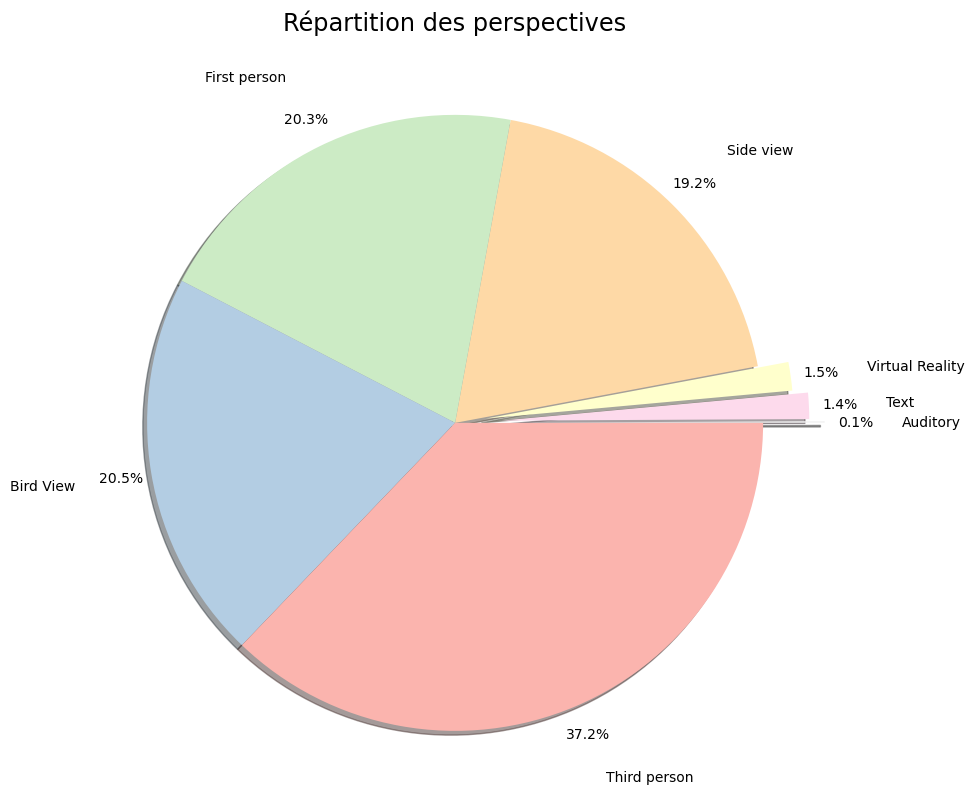

In [31]:
colonnes_cam = ['Auditory', 'Bird View', 'First person', 'Side view', 'Text', 'Third person', 'Virtual Reality']
df_cam = DF[colonnes_cam].sum().sort_values()
myexplode = [0.4, 0.3, 0.2, 0,0,0,0]
dégradé7 = ['#bdd7e7','#eff3ff','#deebf7','#c6dbef','#9ecae1', '#5a9bd4','#1f78b4' ]

colors = plt.cm.Pastel1_r(np.linspace(0, 1, len(df_cam)))

plt.figure(figsize=(5,5))
plt.pie(df_cam, labels=df_cam.index, explode=myexplode,autopct='%1.1f%%',startangle=0,pctdistance=1.1, 
        labeldistance=1.25, colors=colors, radius=2, shadow=True)


plt.title('Répartition des perspectives', y=1.5,fontsize= 'xx-large')
plt.show()


On voit ici que les jeux sont assez inégalement répartis en terme de perspective: il y a presque2x plus de jeux avec une vue à la 3e personne que de jeux avec une vue la 1e personne, une vue du dessus ou de côté. 
On voit qu'il y a très peu de jeux en VR, ce qui est normale puisque cette technologie est encore en développement. 
En ce qui concerne les jeux de type 'Text' et 'Auditory', on voit qu'il y en a aussi très peu dans notre base de données. Ce n'est pas très étonnant car il s'agit de jeux assez spécifiques. 

Etudions aussi la répartition des différents types (genres) de jeux. Il peut s'agir de jeux de combat, de FPS, de course, de sport, de stratégies, de RPG, etc. Mais il peut aussi y avoir des genres plus 'niche':

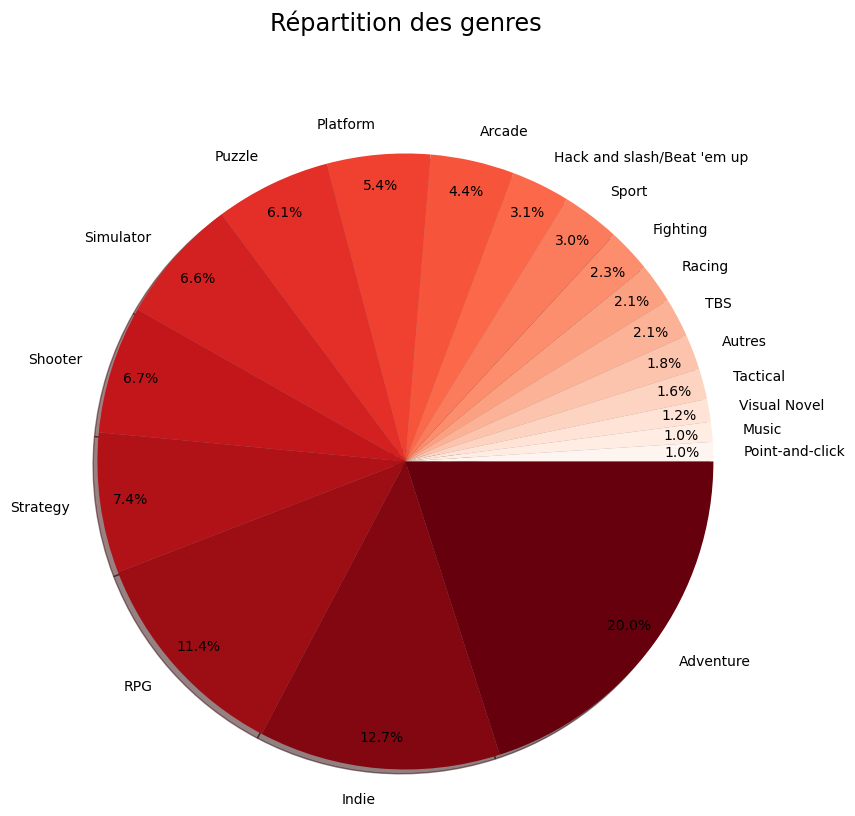

In [32]:
colonnes_cam=list(genre_dictionnary.values())

df_cam = DF[colonnes_cam].sum().sort_values()
dfbis=pd.DataFrame(df_cam)
autres_genres=dfbis[dfbis[0]/dfbis[0].sum()<0.01].index
dfbis.loc['Autres']=dfbis.loc[autres_genres, 0].sum()
dfbis=dfbis.drop(autres_genres)
dfbis=dfbis.sort_values(by=0)

colors = plt.cm.Reds(np.linspace(0, 1, len(dfbis)))

plt.figure(figsize=(5,5))
plt.pie(dfbis[0], labels=dfbis.index,autopct='%1.1f%%',startangle=0,pctdistance=0.9, 
        labeldistance=1.1,colors=colors, radius=2, shadow=True)


plt.title('Répartition des genres', y=1.6,fontsize= 'xx-large')
plt.show()


On voit qu'il y a une grande diversité de genres de jeux. Il y a presque un quart de jeux de type 'Adventure', ie d'un jeu où on suit les pérégrinations d'un personnage principal sur une grande map (type RedDeadRedemption ou Zelda). Les jeux 'Indie' ie indépendants sont également en assez grande proportion: il s'agit de jeux développés par des petites équipes, non financés par des gros studios, donc qui proposent des genres alternatifs avec un gameplay innovant, que l'on ne peut pas vraiment placer dans un genre classique. Mis à part les jeux de type aventure et indépendants, on voit que les différents genres sont assez bien répartis. 

NB: la part 'Autres' du camembert contient des jeux de type Pinball, 
MOB, 
Quiz/Triv, 1
Card & Board Games, dont la proportion au sein du dataframe était trop faible pour en faire des parts distinctes dans le camembert.    

Il peut aussi être intéressant d'étudier la répartition des thèmes des jeux.

Index(['Erotic', '4X', 'Educational', 'Romance', 'Business'], dtype='object')


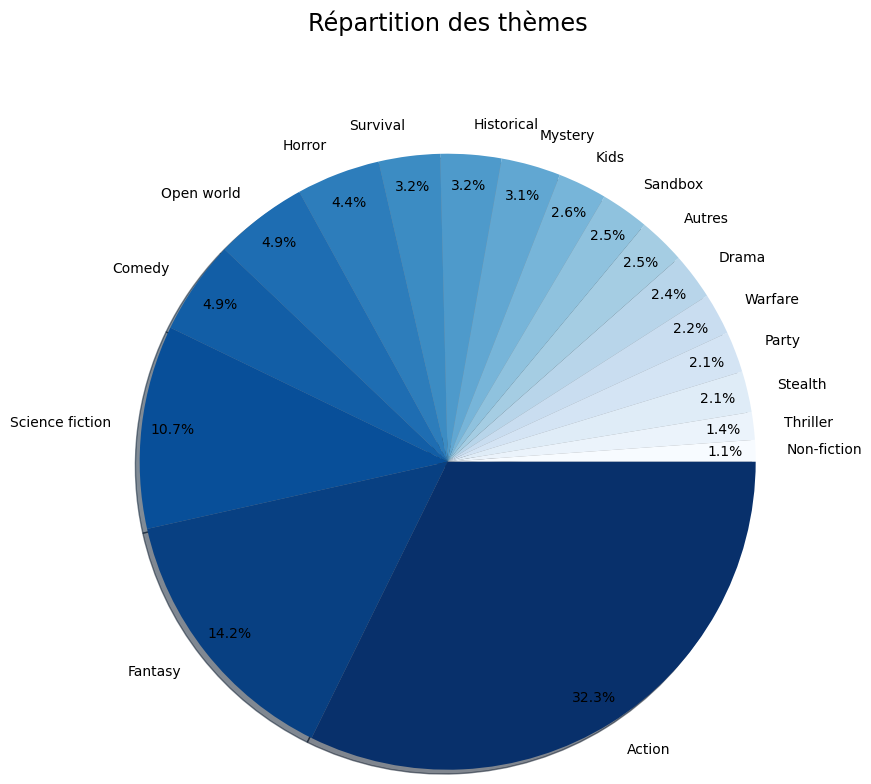

In [33]:
colonnes_cam=list(theme_dictionnary.values())

df_cam = DF[colonnes_cam].sum().sort_values()
dfbis=pd.DataFrame(df_cam)
autres_themes=dfbis[dfbis[0]/dfbis[0].sum()<0.01].index
print(autres_themes)
dfbis.loc['Autres']=dfbis.loc[autres_themes, 0].sum()
dfbis=dfbis.drop(autres_themes)
dfbis=dfbis.sort_values(by=0)

colors = plt.cm.Blues(np.linspace(0, 1, len(dfbis)))

plt.figure(figsize=(5,5))
plt.pie(dfbis[0], labels=dfbis.index,autopct='%1.1f%%',startangle=0,pctdistance=0.9, 
        labeldistance=1.1,colors=colors, radius=2, shadow=True)


plt.title('Répartition des thèmes', y=1.6,fontsize= 'xx-large')
plt.show()

On observe également une grande diversité de thèmes, même si les jeux d'action, fantasy et science fiction sont en proportion plus importante. 
La part 'Autres' du camembert rassemble les jeux de type 4X, d'écudaction, de business, de non-fiction ainsi que les jeux érotiques (!) qui sont en proportion trop faible pour en faire des parts distinctes dans le camembert.

En ce qui concerne la répartition des développeurs principaux: on reprend la liste 'developpeurs' qu'on avait conçue lors de la création des booléens des développeurs. 

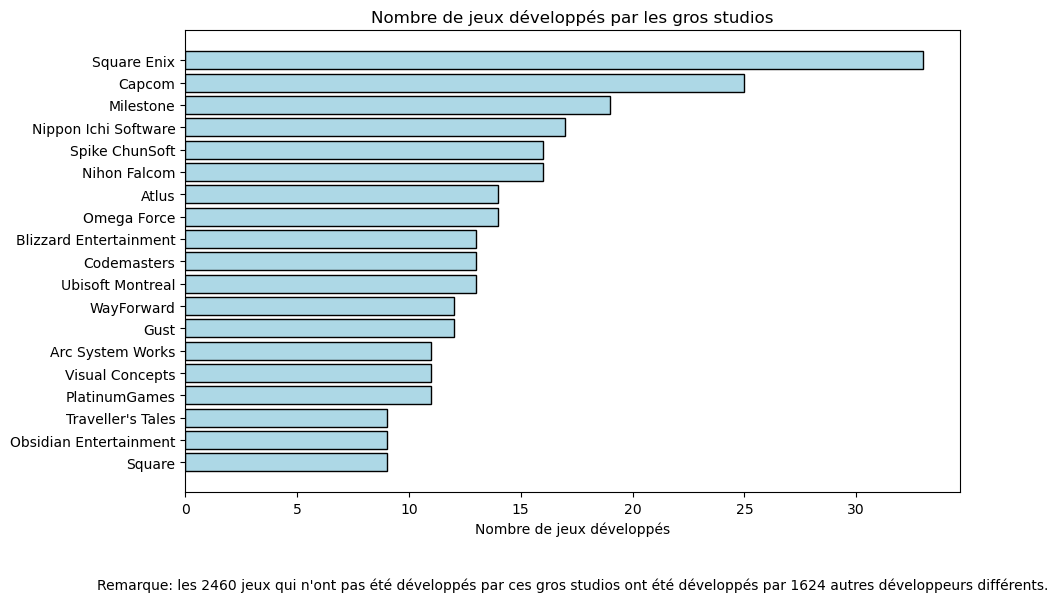

In [34]:
compteur = Counter(developpeurs)


dev_frequents = compteur.most_common(20)

noms, freq = zip(*dev_frequents[1:])

plt.figure(figsize=(10, 6))
plt.barh(noms, freq, color='lightblue',edgecolor='black')
plt.xlabel('Nombre de jeux développés')
plt.title('Nombre de jeux développés par les gros studios')
plt.gca().invert_yaxis() 


nombre_autres_jeux=len(DF)-sum(freq)
nombre_autres_dev=len(set(developpeurs))-20
remarque ='Remarque: les ' + str(nombre_autres_jeux) + ' jeux qui n\'ont pas été développés par ces gros studios ont été développés par ' + str(nombre_autres_dev) + ' autres développeurs différents.'
plt.text(0.5, -0.2, remarque, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10, color='black')

plt.show()

On voit que les gros studios comme Capcom, Square Enix, etc. ont développé plusieurs dizaines de jeux vidéos présents dans notre base. Néanmoins, la base est très fournie et les 20 plus gros studios n'ont en fait développé que 277 des 2737 jeux dans la base. Les 2460 jeux restants ont donc été développés par des plus petits studios, ce qui est à mettre en lien avec la forte proportion de jeux 'indie' qu'on a pu observer dans les genres des jeux. 

Notre base de données est donc éclatée entre une multitude de différents producteurs, puisque le plus gros producteur (Square Enix) n'a produit que 33 des 2737 jeux de la base, soit 1,2% des jeux.


 Qu'en est-il des producteurs de ces jeux vidéos ?

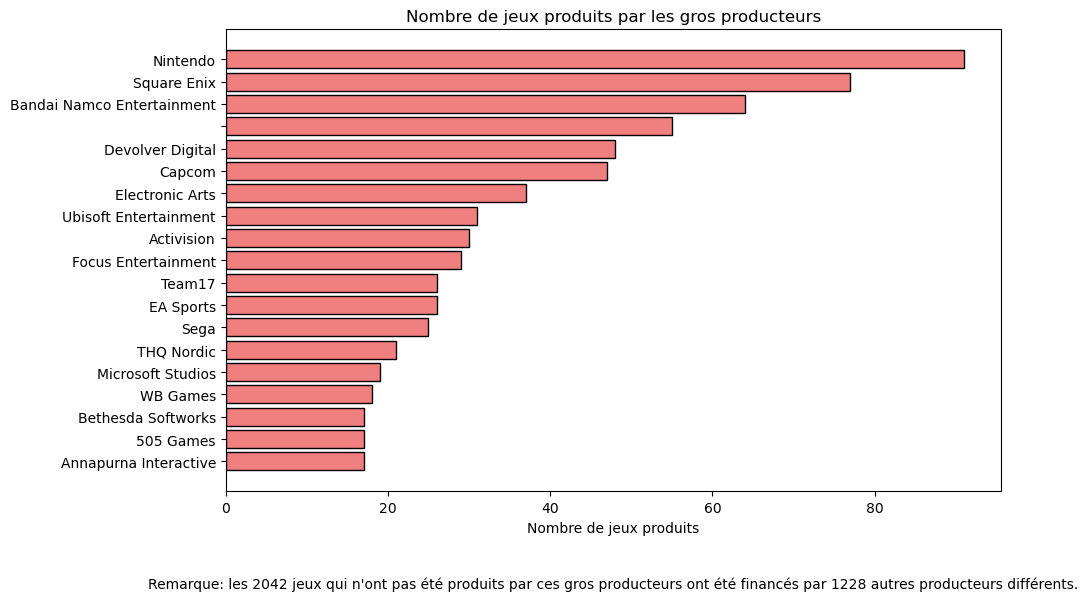

In [35]:
#idem, on recycle la liste 'publishers' qu'on avait créé avant pour concevoir les booléens des gros producteurs.
compteur = Counter(publishers)

prod_frequents = compteur.most_common(20)
prodfrequents=prod_frequents[:3]+prod_frequents[4:] 
noms, freq = zip(*prodfrequents)

plt.figure(figsize=(10, 6))
plt.barh(noms, freq, color='lightcoral',edgecolor='black')
plt.xlabel('Nombre de jeux produits')
plt.title('Nombre de jeux produits par les gros producteurs')
plt.gca().invert_yaxis() 


nombre_autres_jeux=len(DF)-sum(freq)
nombre_autres_dev=len(set(publishers))-20
remarque ='Remarque: les ' + str(nombre_autres_jeux) + ' jeux qui n\'ont pas été produits par ces gros producteurs ont été financés par ' + str(nombre_autres_dev) + ' autres producteurs différents.'
plt.text(0.5, -0.2, remarque, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10, color='black')

plt.show()

Par rapport aux développeurs, on voit que le nombre de jeux produits par des gros producteurs est un peu plus élevé, puisque les 20 plus gros producteurs ont produit chacun entre 17 et 91 jeux. Néanmoins, il y a encore cette fois-ci 2042 jeux qui ont été produits par des plus petits producteurs, au nombre de 1228. 

De même, la base de données est très éclatée entre les différents développeurs, car Nintendo, le plus gros producteur de la base, n'a produit que 91 jeux, soit 3,3% des jeux de la base.


Une autre variable qui peut être intéréssante à visualiser est l'age rating, subdivise les jeux en 3 catégories: 
tout public, pegi 16 et pegi 18.

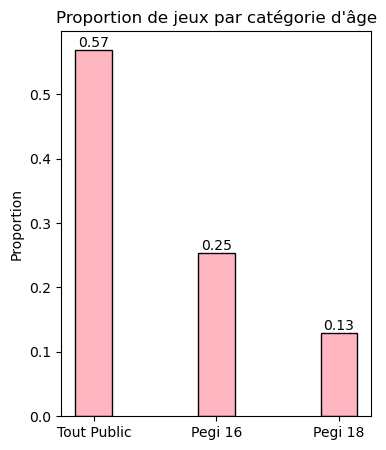

In [36]:
Ages = [('Tout Public',sum(DF['Tout Public']==1)/len(DF)),
        ('Pegi 16',sum(DF['16 year']==1)/len(DF)),
        ('Pegi 18',sum(DF['18 year']==1)/len(DF))]

categories_age, proportions = zip(*Ages)

plt.figure(figsize=(4,5))
bars = plt.bar(categories_age, proportions, width=0.3, color='lightpink', edgecolor='black')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')


plt.ylabel('Proportion')
plt.title('Proportion de jeux par catégorie d\'âge')
plt.show()


On voit que 57% des jeux sont classés 'tout public': cela semble normal car les producteurs n'ont en général pas intérêt à faire des jeux pour un public restreint. Seulement 25% des jeux sont classés pegi 16 et 13% des jeux sont pegi 18.

### III/A/2 Répartition des notes des jeux vidéos

On peut maintenant commencer à visualiser la variable qui nous intéresse le plus, à savoir la note metacritic du jeu. Pour commencer, traçons un histogramme de la répartition des notes:

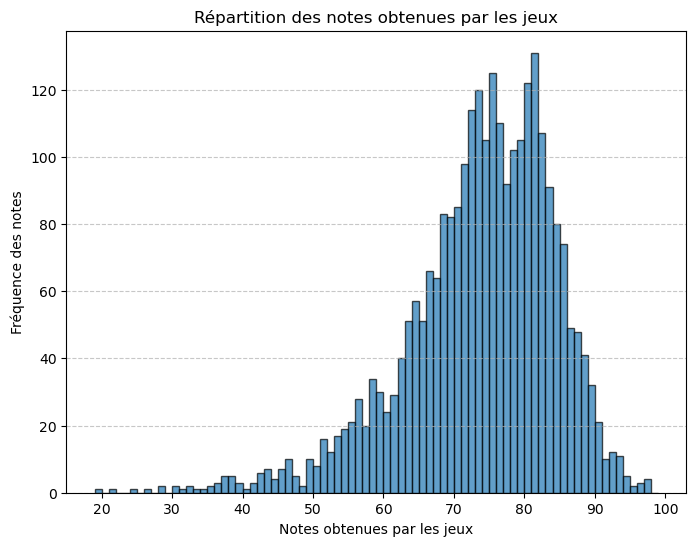

In [37]:

plt.figure(figsize=(8, 6))
plt.hist(DF['Note'], bins=range(int(min(DF['Note'])), 100), edgecolor='black', alpha=0.7)
plt.xlabel('Notes obtenues par les jeux')
plt.ylabel('Fréquence des notes')
plt.title('Répartition des notes obtenues par les jeux')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [66]:
print('la note moyenne est ',DF['Note'].mean())
print('la note médiane est ',DF['Note'].median())
print('les quartiles sont ',DF['Note'].quantile([0.25,0.75]))
print('la note minimum est ',DF['Note'].min(),' elle a été attribuée au jeu ',DF[DF['Note']==DF['Note'].min()]['Title'].to_string(index=False))
print('la note maximum est ',DF['Note'].max(),' elle a été attribuée aux jeux ',DF[DF['Note']==DF['Note'].max()]['Title'].to_string(index=False))

la note moyenne est  73.1611253196931
la note médiane est  75.0
les quartiles sont  0.25    68.0
0.75    81.0
Name: Note, dtype: float64
la note minimum est  19.0  elle a été attribuée au jeu  Alone in the Dark: Illumination
la note maximum est  97.0  elle a été attribuée aux jeux                       Grand Theft Auto V
The Legend of Zelda: Breath of the Wild
                    Super Mario Odyssey
                  Red Dead Redemption 2


D'après notre graphique et les informations ci dessus, il y a une certaine dispersion des notes, entre 19/100 et 97/100. Le jeu ayant obtenu la plus mauvaise note est sans trop de surprise un jeu d'horreur, tandis que ceux qui ont obtenu les meilleures notes sont les iconiques GTA 5, Legend of Zelda, Super Mario Odyssey ainsi que RDR 2. 

Même si les notes extrêmes sont très écartées, il y a tout de même une forte concentration des notes des jeux autours de la moyenne, qui est à 73,16/100. En effet, on voit que la note médiane des jeux est à 75/100, et que la moitié des jeux a une note entre 68/100 et 81/100. 

Pour continuer dans les statistiques descriptives, nous allons mesure la note moyenne obtenue pour des jeux 'Tout Public', 'Pegi 16' ou 'Pegi 18' de manière à voir si une certaine tendance en ressort. Puis, nous allons faire de même pour les perspectives.

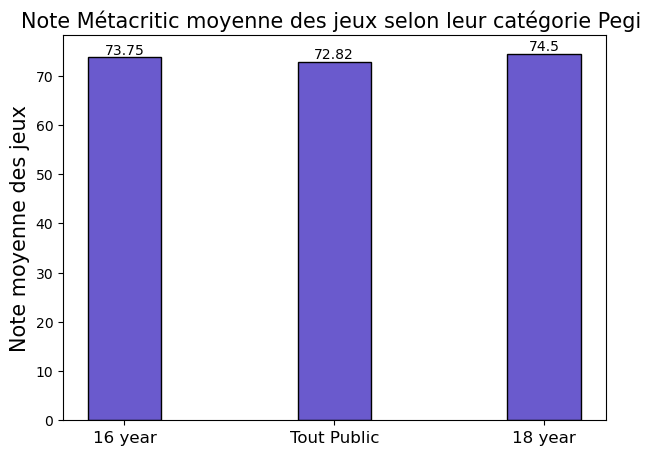

In [165]:
#la liste y_notes_age contient la note moyenne des jeux Tout Public, Pegi 16...
cat1 = list_age_rating
cat2 = list_perspective

y_notes_age = []
for i in cat1 : 
    y_notes_age.append(DF[DF[f'{i}'] == True]['Note'].mean())

y_notes_perspective = []
for j in cat2 : 
    y_notes_perspective.append(DF[DF[f'{j}'] == True]['Note'].mean())

Cat2 = []
sorted_list_perspective = sorted(y_notes_perspective)
for i in sorted_list_perspective : 
    Cat2.append(cat2[y_notes_perspective.index(i)])

x=np.arange(len(y_notes_age))
width= 0.35

fig, ax = plt.subplots(figsize=(7,5))
rects1= ax.bar(x, y_notes_age, width, color='slateblue', edgecolor = "black")

for bar in rects1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

ax.set_ylabel("Note moyenne des jeux", fontsize = 15)
ax.set_title("Note Métacritic moyenne des jeux selon leur catégorie Pegi ", fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(cat1, fontsize=12)

plt.show()

La catégorie Pegi du jeu ne semble pas influencer plus que ça la note du jeu: en moyenne, les jeux "tout public" semblent un peu moins bien notés que les jeux "Pegi 16", qui sont eux-même légèrement moins bien notés que les jeux "Pegi 18".

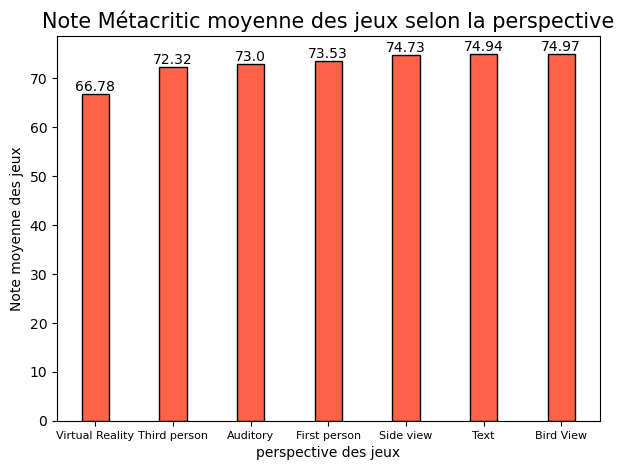

In [167]:
#Pareil ici pour selon la perspective
x = np.arange(len(y_notes_perspective))
width= 0.35

fig, ax = plt.subplots(figsize=(7,5))
rects1= ax.bar(x, sorted_list_perspective, width, color = 'Tomato', edgecolor = "black")
ax.set_xlabel("perspective des jeux")
ax.set_ylabel("Note moyenne des jeux")
ax.set_title("Note Métacritic moyenne des jeux selon la perspective", fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(Cat2, fontsize = 8)

for bar in rects1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')


plt.show()

La perspective du jeu semble un peu plus avoir un impact sur la note du jeu. On voit ici par exemple que ce sont les jeux en réalité virtuelle qui ont les pire notes en moyenne. Cela ne semble pas très étonnant puisqu'il s'agit encore d'une technologie très récente et pas encore au point, donc qui peut facilement décevoir les utilisateurs des jeux.

Il peut aussi être intéressant de voir si le nombre de plateformes sur lequel un jeu est disponible impacte la note du jeu. C'est probable puisque le nombre de plateformes est un proxy du nombre d'utilisateurs du jeu, information à laquelle on n'a pas accès.  

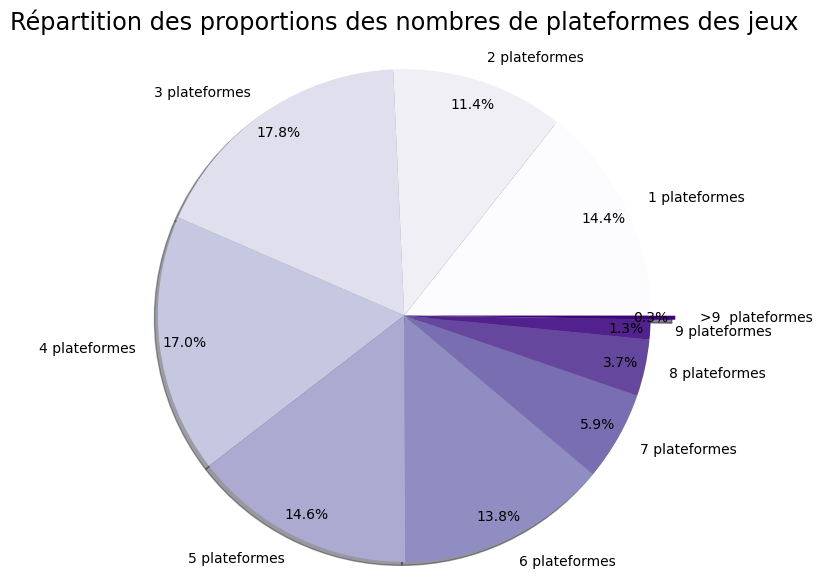

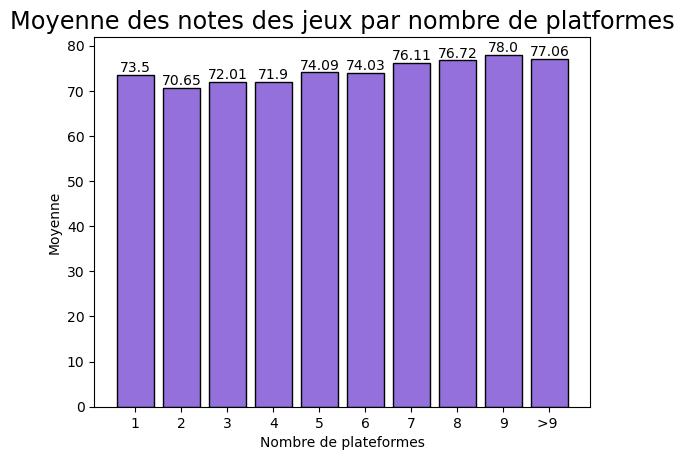

In [161]:
Nbr_platformes = [(i, DF[DF['nb_platforms'] == i]['Note'].count(),DF[DF['nb_platforms'] == i]['Note'].mean()) for i in set(DF["nb_platforms"])]

dfbis=pd.DataFrame(Nbr_platformes)

#on fait d'abord un camembert qui montre que les jeux étant présents sur plus de 10 plateformes sont en très faible proportion
autresprop=dfbis[dfbis[1]/dfbis[1].sum()<0.01].index
dfbis.loc['>9 ']=dfbis.loc[autresprop].mean()
dfbis=dfbis.drop(autresprop)
dfbis['indexbis'] = dfbis.index.astype(str) + ' plateformes'
dfbis['indexbisbis'] = dfbis.index.astype(str)

myexplode=np.zeros(len(dfbis))
myexplode[len(dfbis)-1]=0.2
colors = plt.cm.Purples(np.linspace(0, 1,len(dfbis)))

plt.figure(figsize=(4,4))
plt.pie(dfbis[1],labels=dfbis['indexbis'], explode=myexplode, autopct='%1.1f%%',startangle=0,pctdistance=0.9, 
        labeldistance=1.1,colors=colors, radius=2, shadow=True)

plt.title('Répartition des proportions des nombres de plateformes des jeux', y=1.4,fontsize= 'xx-large')
plt.show()


#on peut ensuite tracer le barplot des notes moyennes en fonction du nombre de plateformes
plt.figure()
bars = plt.bar(dfbis['indexbisbis'], dfbis[2], color = 'mediumpurple', edgecolor = 'black')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')


plt.xlabel('Nombre de plateformes')
plt.ylabel('Note moyenne')
plt.title('Moyenne des notes des jeux par nombre de platformes',y=1.4,fontsize= 'xx-large')
plt.show()

Une tendance semble se dégager: plus le jeu est accessible sur un nombre élevé de plateformes, plus sa note semble élevée. On peut se permettre de ne pas prendre en compte les jeux accessibles sur plus de 9 plateformes, car le camembert montre que leur proportion est totalement anectodique. 
Comme le nombre de plateformes est un proxy du nombre d'utilisateurs du jeu, il semble que la note du jeu est croissante avec le nombre d'utilisateurs: ceci est plutôt logique car si il y a beaucoup d'utilisateurs, c'est que le jeu est populaire donc probablement de bonne qualité. 

Il est aussi intéressant de voir comment les notes des jeux sont réparties en fonction de leur thème et leur genre: il est en effet fort probable que certains thèmes/genres obtiennent en moyenne de meilleures moyennes que d'autres. 

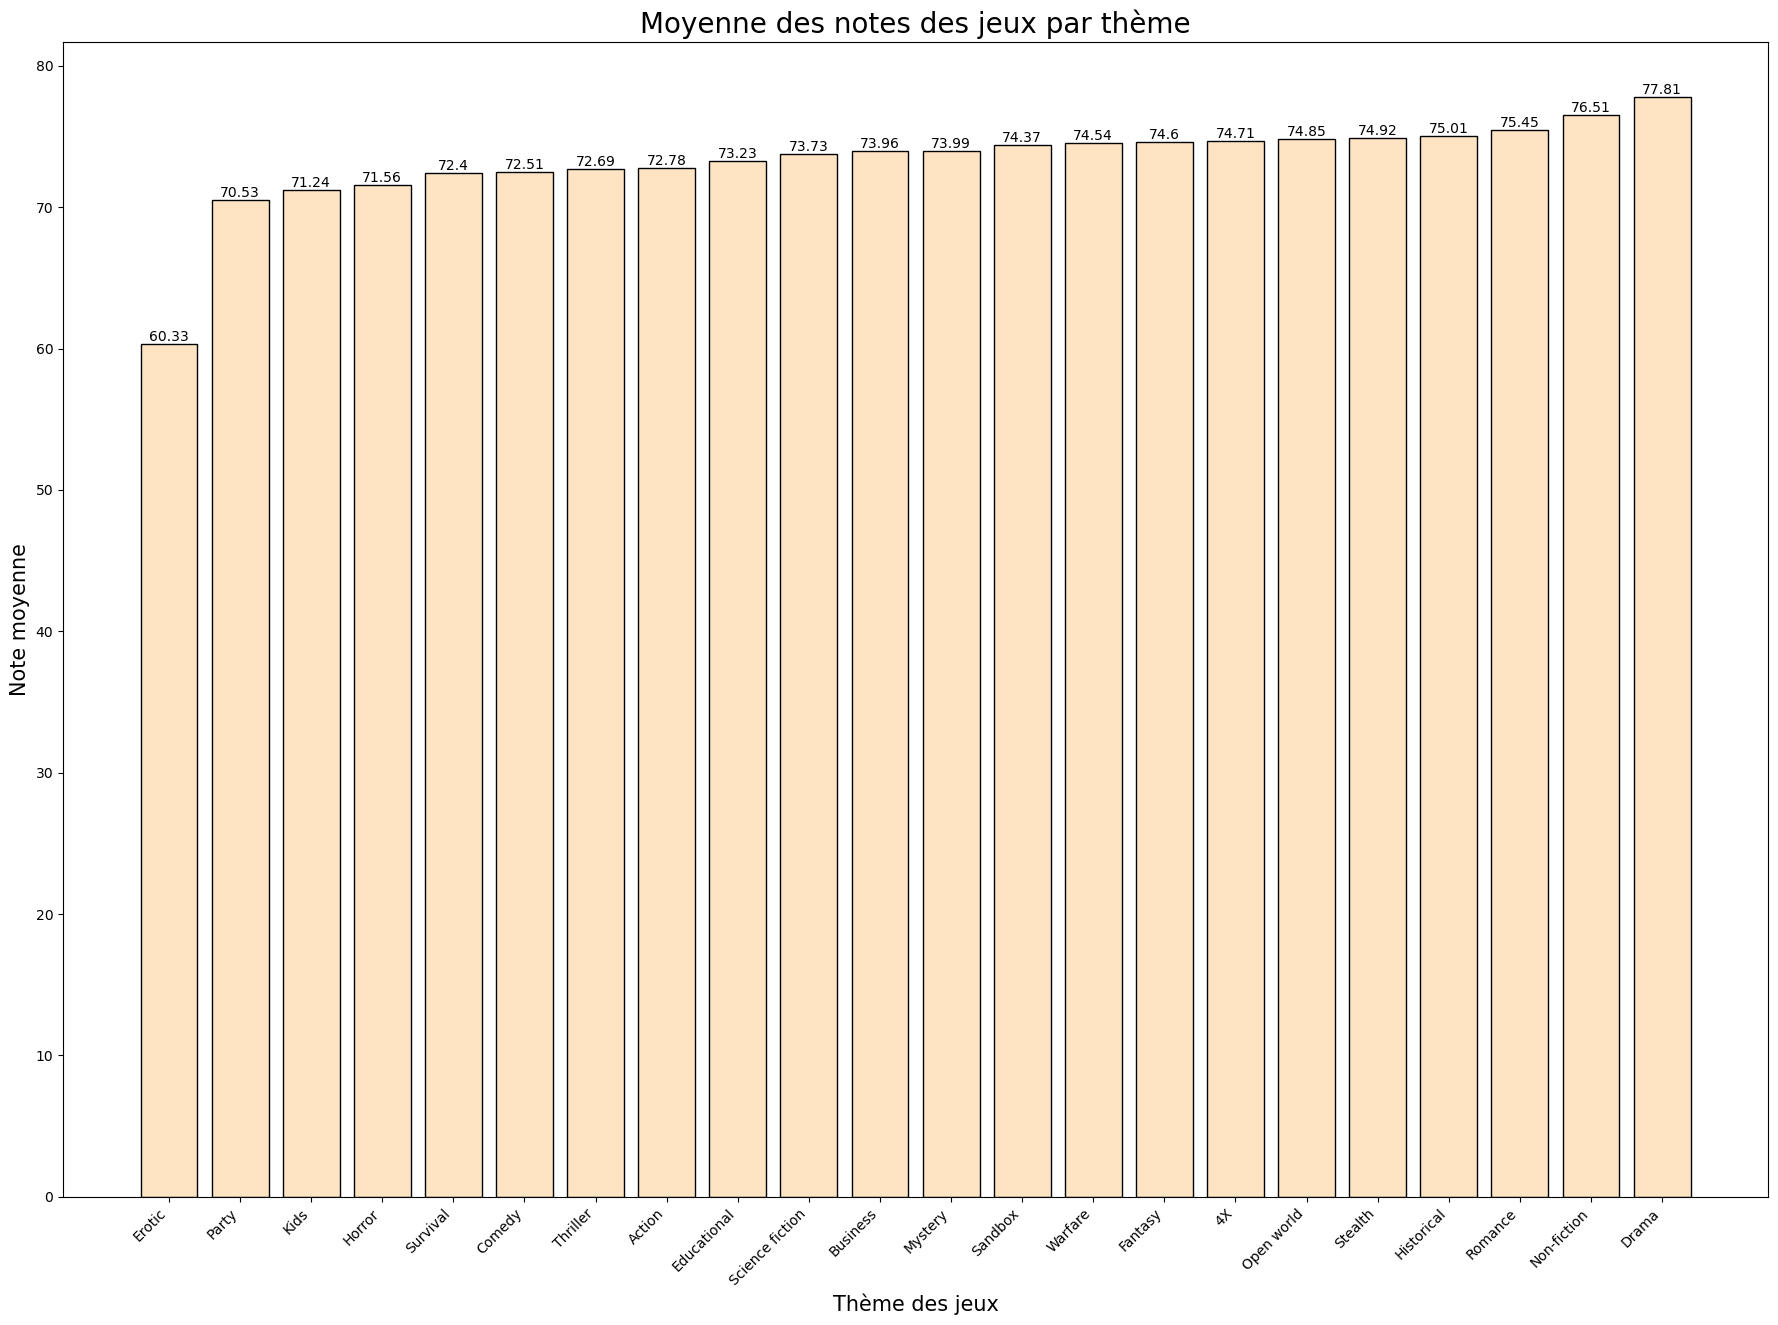

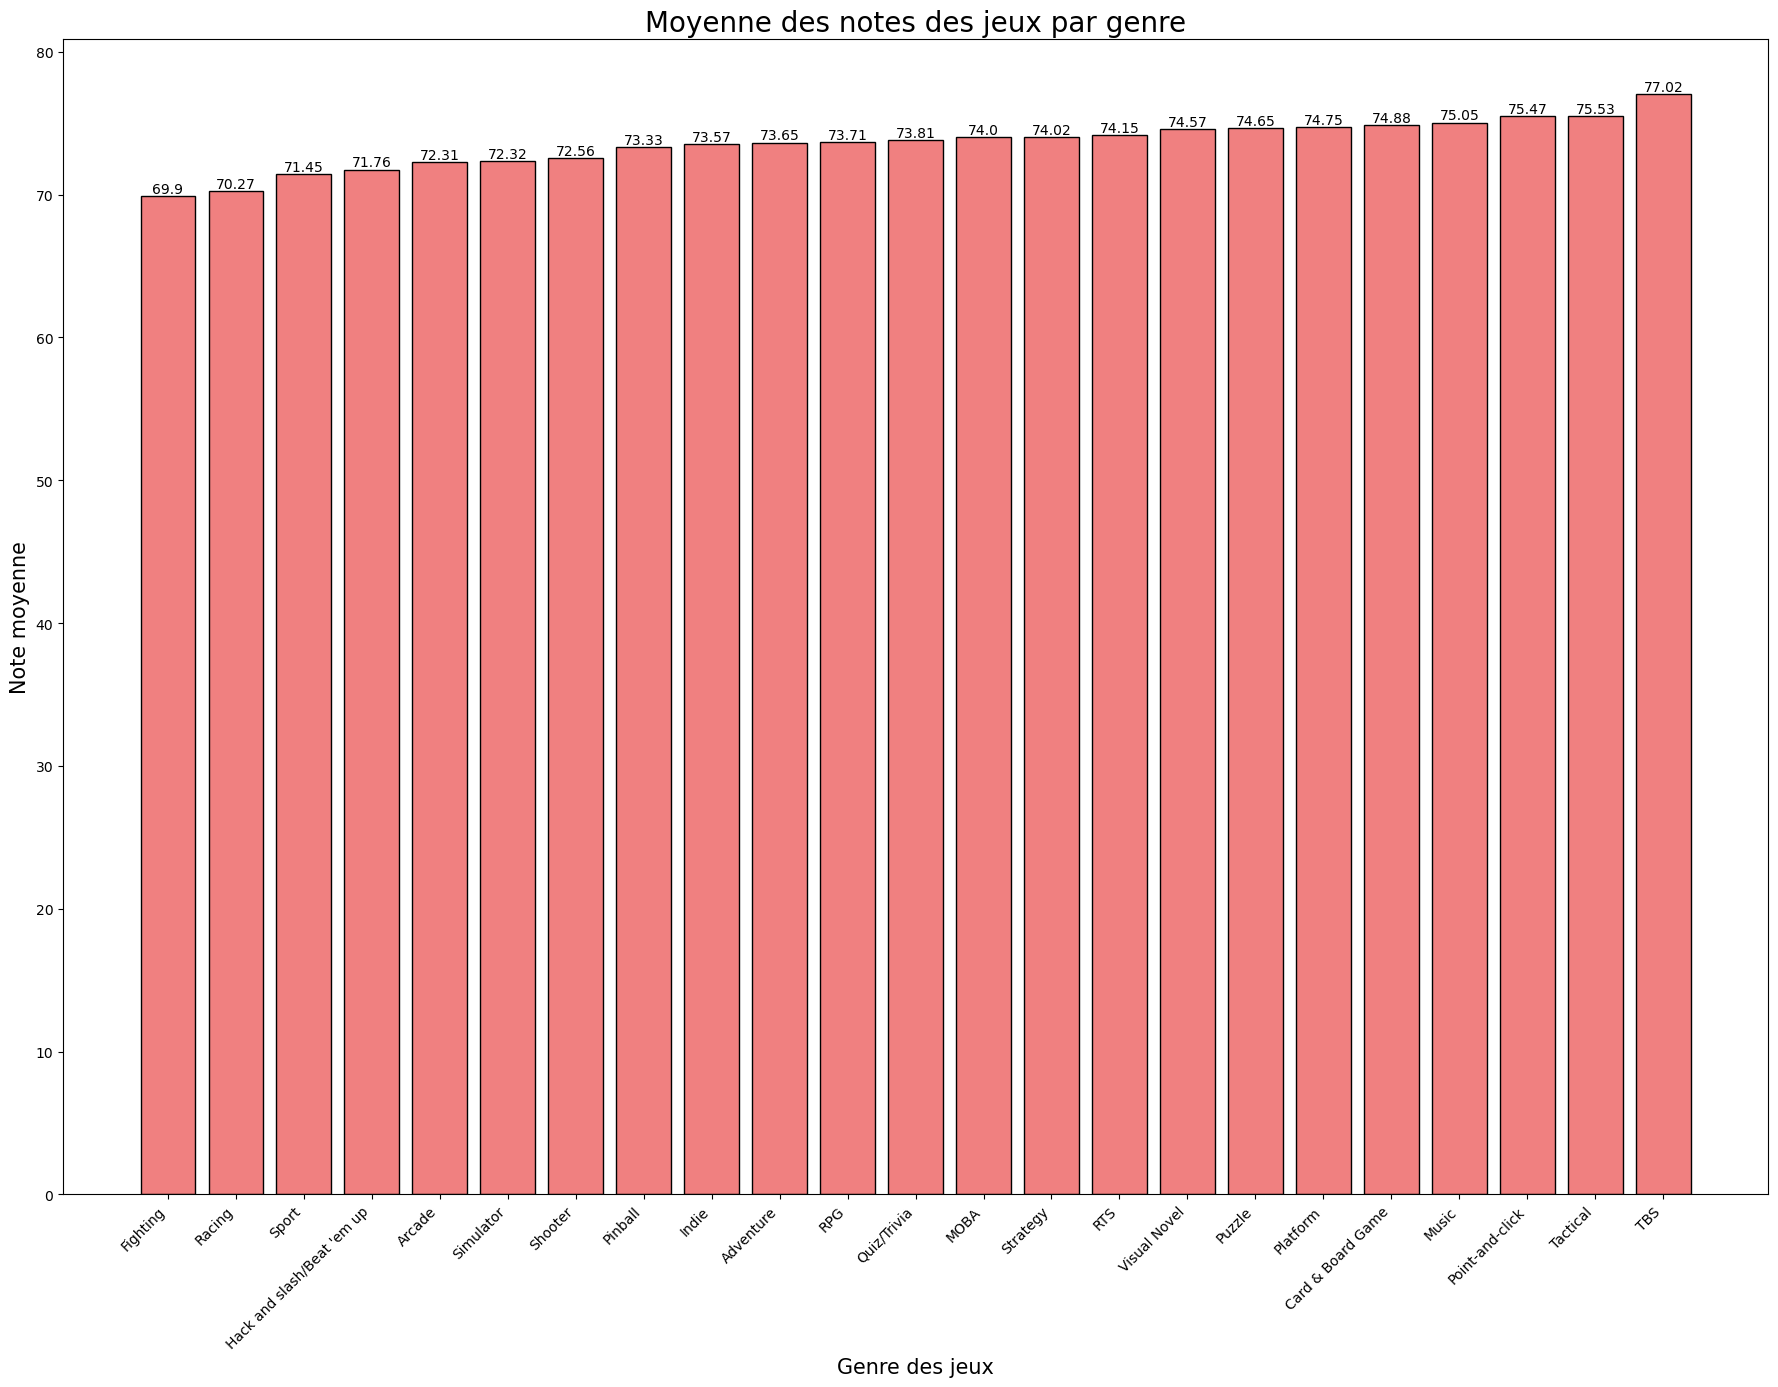

In [216]:
#pour les themes 

themes_liste = [(str(i), DF[DF[i] == 1]['Note'].mean()) for i in list(theme_dictionnary.values())]
themes_liste=pd.DataFrame(themes_liste)
themes_liste = themes_liste.sort_values(by=1)


plt.figure(figsize=(22,15))
bars= plt.bar(themes_liste[0], themes_liste[1], color = 'bisque',edgecolor='black')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')


plt.xticks(rotation=45, ha='right')
plt.ylabel('Note moyenne',fontsize= 15)
plt.xlabel('Thème des jeux',fontsize = 15)
plt.title('Moyenne des notes des jeux par thème',fontsize=20)
plt.show()


#pour les genres 

genre = [(str(i), DF[DF[i] == 1]['Note'].mean()) for i in list(genre_dictionnary.values())]

genre=pd.DataFrame(genre)
genre = genre.sort_values(by=1)


plt.figure(figsize=(22,15))
bars= plt.bar(genre[0], genre[1], color = 'lightcoral',edgecolor='black')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')


plt.xticks(rotation=45, ha='right')
plt.ylabel('Note moyenne',fontsize= 15)
plt.xlabel('Genre des jeux',fontsize = 15)
plt.title('Moyenne des notes des jeux par genre',fontsize=20)
plt.show()

On voit en effet que les jeux ont en moyenne des notes différents en fonction de leur thèmes/genre. 

-Pour les thèmes : les jeux qui obtiennent en moyenne des meilleures notes sont ceux de theme 'Drama', tandis que ceux qui recoivent en moyenne les moins bonnes notes sont ceux de thème 'erotic', ce qui n'est pas très surprenant car on voit mal comment un jeu de ce type peut être de bonne qualité.

-pour les genres: les jeux qui obtiennent en moyenne les meilleures notes sont ceux de type TBS (jeux de stratégie type 'warhammer 40k' tandis que ceux qui obtiennent en moyenne les moins bonnes notes sont les jeux de combat 'fighting'

Enfin, on peut voir comment les notes des jeux sont réparties en fonction de leur producteur/développeur. Comme évoqué précédemment, ces variables sont des bons proxys du budget du jeu car les gros producteurs/développeurs ont souvent un gros budget. 

In [223]:

genre = [(str(i), DF[DF[i] == 1]['Note'].mean()) for i in list(developpeurs)]

genre=pd.DataFrame(genre)
genre = genre.sort_values(by=1)


plt.figure(figsize=(22,15))
bars= plt.bar(genre[0], genre[1], color = 'lightcoral',edgecolor='black')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')


plt.xticks(rotation=45, ha='right')
plt.ylabel('Note moyenne',fontsize= 15)
plt.xlabel('Genre des jeux',fontsize = 15)
plt.title('Moyenne des notes des jeux par genre',fontsize=20)
plt.show()

KeyError: 'FromSoftware'

## III/B Corrélation entre les variables



nb de jv par date de sortie 
répartition des notes 
répartition du nb de plateformes 



faire des barblots avec les notes associées aux themes/genres/producteurs/developpeurs etc 
regarder si les notes des jeux sont meilleures en 2020 pendant le covid ou si ça change rien ok

A faire: note en fonction de développeur / publisher 

A partir des colonnes, on peut faire la répartition des age_rating, jeux qui font partie d'une franchise/collection, régression sur la hype/nb_languages/nb_platforms/graphismes... Les publishers/devs/etc comment on les traitent sachant que beaucoup de diversité de variables (est ce qu'on fait une liste des plus récurrents => les plus connus). Avec les similar games, si on arrive à avoir des notes, à quel point c'est corrélé avec la note du jeu en question. 

Faire analyse ACP du profil d'un bon jeu

Vérifier que l'on n'a pas de lignes redondantes dans la base

Age Rating faire 3 colonnes de booléens (Tout Public/ 16/ 18) -> fait

Publisher/Developer -> créer un boléen pour les plus populaires/fréquents/big -> fait 

Faire colonne moyenne des notes des jeux similaires (voir si pertinent puis on pourra régresser) -> fait et à priori aucun des id n'est dans la base

Why not voir des booléens sur game engines si y en a pas trop ou alors les plus fréquents -> fait 

IMPORTANT: faire une case de texte avnt de créer les booleens ou on dit qu'on suppose que les trucs sur lesquels on créé les booleens auront un impact sur la note du jeu: puis on testera cette hypothèse avec la visualisation

à revoir: collection = que des 'yes' alors que ça devrait pas: revoir l'extraction, lors du test 
if games[0].collection is None or games[0].collection == [] : 
        collec = 'NO'
    else : 
        collec = 'Yes'
--> ça fait de la merde
 fait




In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
#premiere regression linéaire avec scikit (elle marche tres mal)
#un dataset tres basique 

df2 = DF.select_dtypes(include=['int', 'float']).copy()
df2 = df2.drop("Id", axis=1).drop("index", axis=1).dropna().astype(np.float64)
print(df2.columns)

#on run le modèle avec les fonctions prebuilt
X_train, X_test, y_train, y_test = train_test_split(
    df2.drop(["Note"], axis = 1),
    df2[['Note']].values.ravel(), test_size=0.2, random_state=0
)

ols = LinearRegression().fit(X_train, y_train)
y_pred = ols.predict(X_test)
print(y_pred[:10])
df2["Note"][:10]

In [ ]:
rmse = sklearn.metrics.mean_squared_error(y_test, y_pred, squared = False)
rsq = sklearn.metrics.r2_score(y_test, y_pred) 

print(rmse)
print(rsq)

#moyenne, R2

In [ ]:

tempdf = pd.DataFrame({"prediction": y_pred, "vraie note": y_test,
                       "erreur": y_test - y_pred})

fig = plt.figure()
g = sns.scatterplot(data = tempdf, x = "vraie note", y = "prediction")
g.axhline(0, color = "red")


In [ ]:
tempdf = pd.DataFrame({"prediction": y_pred, "vraie note": y_test,
                       "erreur": y_test - y_pred})

fig = plt.figure()
g = sns.scatterplot(data = tempdf, x = "vraie note", y = "erreur")
g.axhline(0, color = "red")




In [ ]:
#autre methode qui utilise statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:

df2 = DF.select_dtypes(include=['int', 'float']).copy()
df2 = df2.drop("Id", axis=1).drop("index", axis=1).dropna().astype(np.float64)
print(df2.head())


X = sm.add_constant(df2.drop(["Note"], axis = 1))
results = sm.OLS(df2[['Note']], X).fit()
print(results.summary())
print(results.params)

#meilleur résultats, il faut coder une fonction qui donne une représentation graphique en fonction des paramètres de la regression
